In [506]:
from Utils import *

In [507]:
def add_padding(original_image, padding = 10):
    original_image = cv.copyMakeBorder(original_image, padding, padding, padding, padding, cv.BORDER_CONSTANT, value=0)
    
    return original_image

In [508]:
def opening(original_image):
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
    word = cv.morphologyEx(original_image, cv.MORPH_OPEN, kernel)

    return word

In [509]:
def closing(original_image):
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
    word = cv.morphologyEx(original_image, cv.MORPH_CLOSE, kernel)

    return word

In [510]:
def get_contours(word):
    contours, _ = cv.findContours(word, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    return contours

In [511]:
def fill_holes(contours, word):
    max_area = np.max([cv.contourArea(contour) for contour in contours])
    #remove contours that are too small
    small_contours = [contour for contour in contours if cv.contourArea(contour) < max_area * 0.1]
    #fill the small contours Wwith black
    for contour in small_contours:
        word = cv.drawContours(word, [contour], 0, (0, 0, 0), -1)

In [512]:
def get_horizontal_projection(word):
    horizontal_projection = np.sum(word, axis=1)
    return horizontal_projection

In [513]:
def get_max_value_in_hp(horizontal_projection):
    max_value_horizontal_proj = np.max(horizontal_projection)
    max_index_global_horizontal = np.where(horizontal_projection == max_value_horizontal_proj)[0][0]
    return max_value_horizontal_proj, max_index_global_horizontal

In [514]:
def get_local_minimas_horizontal(horizontal_projection):
    local_minimas_horizontal = []
    for i in range(1, len(horizontal_projection) - 1):
        if horizontal_projection[i] > 0 and horizontal_projection[i - 1] == 0:
            local_minimas_horizontal.append(i)

        elif horizontal_projection[i] == 0 and horizontal_projection[i - 1] > 0:
            local_minimas_horizontal.append(i)
            
    return local_minimas_horizontal

In [515]:
def filter_local_minimas(local_minimas_horizontal):
    if len(local_minimas_horizontal) > 2:
        max_diff = 0
        max_diff_index = 0
        for i in range(1, len(local_minimas_horizontal)):
            diff = local_minimas_horizontal[i] - local_minimas_horizontal[i-1]
            if diff > max_diff:
                max_diff = diff
                max_diff_index = i

        fitered_local_minimas = [local_minimas_horizontal[max_diff_index - 1], local_minimas_horizontal[max_diff_index]]
    else:
        fitered_local_minimas = local_minimas_horizontal
    return fitered_local_minimas

In [516]:
def fill_no_text_areas(word, filtered_local_minimas):
    min_local_minima = min(filtered_local_minimas)
    max_local_minima = max(filtered_local_minimas)

    #fill the area below the min local minima with black
    word[:min_local_minima] = 0
    #fill the area above the max local minima with black
    word[max_local_minima:] = 0
    return word

In [517]:
def get_text_top_and_bottom(fitered_local_minimas, max_index_global_horizontal):
    text_top_height = min(fitered_local_minimas) - max_index_global_horizontal
    text_bottom_height = max(fitered_local_minimas) - max_index_global_horizontal
    return text_top_height, text_bottom_height

In [518]:
def get_vertical_projection(word):
    vertical_projection = np.sum(word, axis=0)
    return vertical_projection

In [519]:
def find_local_minimas_in_vp(vertical_projection):
    local_minimas = []
    for i in range(1, len(vertical_projection) - 1):
        if vertical_projection[i] <= vertical_projection[i - 1] and vertical_projection[i] <= vertical_projection[i + 1]:
            local_minimas.append(i)
    return local_minimas

In [520]:
def detect_stable_regions(projection, threshold=500):
    derivative = np.diff(projection)
    
    stable_indices = np.where(np.abs(derivative) < threshold)[0]
    
    if len(stable_indices) == 0:
        return []

    regions = []
    start = stable_indices[0]

    for i in range(1, len(stable_indices)):
        if stable_indices[i] != stable_indices[i - 1] + 1:
            regions.append((start, stable_indices[i - 1]))
            start = stable_indices[i]
    
    regions.append((start, stable_indices[-1]))
    
    return regions

In [521]:
def get_average_values(vertical_projection, stable_areas):
    average_values = []
    for start, end in stable_areas:
        average_values.append(np.mean(vertical_projection[start:end]))
    return average_values

In [522]:
def merge_stable_areas(stable_areas, width, average_values):
    merged_areas = []
    threshold = width * 0.03
    if len(stable_areas) == 0:
        return merged_areas

    start, end = stable_areas[0]
    
    for i in range(1, len(stable_areas)):
        next_start, next_end = stable_areas[i]
        if next_start - end <= threshold and np.abs(average_values[i] - average_values[i - 1]) <= 500:
            end = next_end
        else:
            merged_areas.append((start, end))
            start, end = next_start, next_end
    
    merged_areas.append((start, end))
    
    return merged_areas

In [523]:
def filter_small_areas(merged_areas, width):
    merged_areas = [area for area in merged_areas if area[1] - area[0] > width * 0.005]
    return merged_areas

In [524]:
def get_avg_value_of_merged_areas(merged_areas, vertical_projection):
    avg_values = []
    for start, end in merged_areas:
        avg_values.append(np.mean(vertical_projection[start:end]))
    return avg_values

In [525]:
def filter_too_high_vp(average_values_merged, merged_areas):
    filtered_areas = []
    for i, value in enumerate(average_values_merged):
        if value < np.percentile(average_values_merged, 80):
            filtered_areas.append(merged_areas[i])
    return filtered_areas

In [526]:
def filter_by_text_line(skeleton_image_for_use_here, filtered_areas, text_top_height, max_index_global_horizontal, text_bottom_height, word):
    filtered = []
    empty_areas = []
    #get the average positions of white pixels that fall inside each area
    top_height_allowance = (text_top_height - max_index_global_horizontal)  * 0.5
    bottom_height = (text_bottom_height - max_index_global_horizontal) * 0.5

    for start, end in filtered_areas:
        mid = (start + end) // 2
        text_slice = skeleton_image_for_use_here[:, mid]
        text_indices = np.where(text_slice == 255)[0]
        if len(text_indices) == 0:
            empty_areas.append((start, end))
            continue
        #if there is a difference between each consecutive text indices that is more than 1, then the text is not continuous
        if np.any(np.diff(text_indices) > 1):
            continue
        
        #average_text_index = np.mean(text_indices)
        max_text_index = np.max(text_indices)
        min_text_index = np.min(text_indices)
        
        if max_text_index > max_index_global_horizontal + 0.4 * abs(text_top_height) or min_text_index < max_index_global_horizontal - 0.4 * text_bottom_height:
            continue
        else:
            filtered.append((start, end))
        # if average_text_index == max_index_global_horizontal or average_text_index - max_index_global_horizontal < max_index_global_horizontal + top_height_allowance or max_index_global_horizontal - average_text_index > max_index_global_horizontal + bottom_height:
        #     filtered.append((start, end))

    #check if empty areras falls within the text or at the start and begining only
    for start, end in empty_areas:
        #check if there is white pixel from start of image to the start of the empty area or from the end of the empty area to the end of the image
        if np.any(word[:, :start] == 255) and np.any(word[:, end:] == 255):
            filtered.append((start, end))
    return filtered, empty_areas

In [527]:
def filter_by_distances(filtered):
    #get average distance between each consecutive area
    filtered = sorted(filtered, key=lambda x: x[0])
    distances = [filtered[i][0] - filtered[i - 1][0] for i in range(1, len(filtered))]
    avg_distance = np.mean(distances)

    filtered_by_distance = []
    for start, end in filtered:
        if filtered_by_distance and start - filtered_by_distance[-1][1] < avg_distance * 0.2:
            # If the start of the current interval is close to the end of the last interval in the list, merge them
            filtered_by_distance[-1] = (filtered_by_distance[-1][0], max(end, filtered_by_distance[-1][1]))
        else:
            # If not, add the current interval to the list
            filtered_by_distance.append((start, end))
    return filtered_by_distance

In [528]:
def get_split_points(filtered_by_distance, vertical_projection):
    split_points = []
    for start, end in filtered_by_distance:
        min_value = np.min(vertical_projection[start:end])
        min_index = np.where(vertical_projection[start:end] == min_value)[0][0] + start
        split_points.append(min_index)
    return split_points

In [529]:
def segment_characters(path):
    original_image = cv.imread(path, cv.IMREAD_GRAYSCALE)

    original_image = add_padding(original_image)

    word = opening(original_image)

    word = closing(original_image)

    word = opening(original_image)

    show_images([original_image, word], ["Original Image", "Preprocessed Image"])
    
    contours = get_contours(word)
    
    fill_holes(contours, word)
    show_images([original_image, word], ["Original Image", "Filled Holes Image"])

    horizontal_projection = get_horizontal_projection(word)

    max_value_horizontal_proj, max_index_global_horizontal = get_max_value_in_hp(horizontal_projection)
    
    #draw a line at the max_index_global_horizontal to show the text line
    image_copy_6 = word.copy()
    image_copy_6[max_index_global_horizontal] = 255
    show_images([original_image, image_copy_6], ["Original Image", "Text Line Image"])


    local_minimas_horizontal = get_local_minimas_horizontal(horizontal_projection)

    filtered_local_minimas = filter_local_minimas(local_minimas_horizontal)

    word = fill_no_text_areas(word, filtered_local_minimas)

    text_top_height, text_bottom_height = get_text_top_and_bottom(filtered_local_minimas, max_index_global_horizontal)

    vertical_projection = get_vertical_projection(word)
    #plot the vertical projection
    plt.plot(vertical_projection)
    plt.title("Vertical Projection")
    plt.show()

    local_minimas  = find_local_minimas_in_vp(vertical_projection)

    stable_areas = detect_stable_regions(vertical_projection)
    
    #plot the stable areas on the vertical projection
    for start, end in stable_areas:
        #color the stable areas in yellow
        plt.axvline(start, color='y')
        plt.axvline(end, color='y')
        
    plt.title("Vertical Projection with stable areas")
    plt.plot(vertical_projection)

    average_values = get_average_values(vertical_projection, stable_areas)
    #plot the average values of the stable areas on the vertical projection
    for i, value in enumerate(average_values):
        plt.axhline(value, color='g')
    plt.title("Vertical Projection with stable areas and average values")
    plt.show()

    merged_areas = merge_stable_areas(stable_areas, word.shape[1], average_values)
    #draw the merged areas on the image
    image_copy_2 = word.copy()
    for start, end in merged_areas:
        image_copy_2[:, start] = 255
        image_copy_2[:, end] = 255
    show_images([original_image, image_copy_2], ["Original Image", "Merged Areas Image by stability"])

    height, width = word.shape

    merged_areas = filter_small_areas(merged_areas, width)
    #draw the filtered areas on the image
    image_copy_1 = word.copy()
    for start, end in merged_areas:
        image_copy_1[:, start] = 255
        image_copy_1[:, end] = 255
    show_images([original_image, image_copy_1], ["Original Image", "Filtered Areas Image by width"])

    average_values_merged = get_avg_value_of_merged_areas(merged_areas, vertical_projection)

    filtered_areas = filter_too_high_vp(average_values_merged, merged_areas)
    image_copy = word.copy()
    for start, end in filtered_areas:
        image_copy[:, start] = 255
        image_copy[:, end] = 255
    show_images([original_image, image_copy], ["Original Image", "Filtered Areas Image by average value"])

    skeleton = skeletonize(word)
    skeleton_image = np.where(skeleton, 255, 0).astype(np.uint8)
    
    filtered, empty_areas = filter_by_text_line(skeleton_image, filtered_areas, text_top_height, max_index_global_horizontal, text_bottom_height, word)
    image_copy_3 = word.copy()
    for start, end in filtered:
        image_copy_3[:, start] = 255
        image_copy_3[:, end] = 255
    show_images([original_image, image_copy_3], ["Original Image", "Filtered Areas Image by text line"])

    filtered_by_distance = filter_by_distances(filtered)
    image_copy_4 = word.copy()
    for start, end in filtered_by_distance:
        image_copy_4[:, start] = 255
        image_copy_4[:, end] = 255
    show_images([original_image, image_copy_4], ["Original Image", "Filtered Areas Image by distance"])
    split_points = get_split_points(filtered_by_distance, vertical_projection)

    
    if len(split_points) == 0:
        return [original_image]
    
    image_copy_5 = word.copy()
    
    for point in split_points:
        image_copy_5[:, point] = 255
    show_images([original_image, image_copy_5], ["Original Image", "Split Points Image"])

    words = []
    words.append(original_image[:, :split_points[0]])
    for i in range(len(split_points) - 1):
        words.append(original_image[:, split_points[i]:split_points[i + 1]])
    words.append(original_image[:, split_points[-1]:])
    
    return words

In [530]:
def filter_words(words):
    print('words:', len(words))
    if len(words) == 1 or len(words) == 0:
        return words
    filtered_words = []
    average_width = np.mean([word.shape[1] for word in words])
    for word in words:
        height, width = word.shape
        if width < average_width * 0.5:
            #check amount of white pixels in the word
            white_pixels = np.sum(word == 255)
            print('white pixels:', white_pixels)
            print('total pixels:', height * width)
            print('percentage:', white_pixels / (height * width))
            if white_pixels / (height * width) <= 0.15:
                continue
        filtered_words.append(word)
    return filtered_words

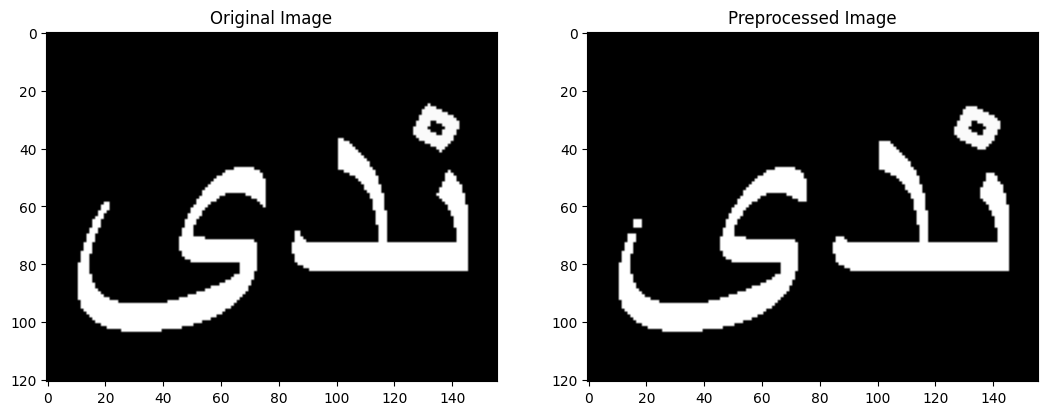

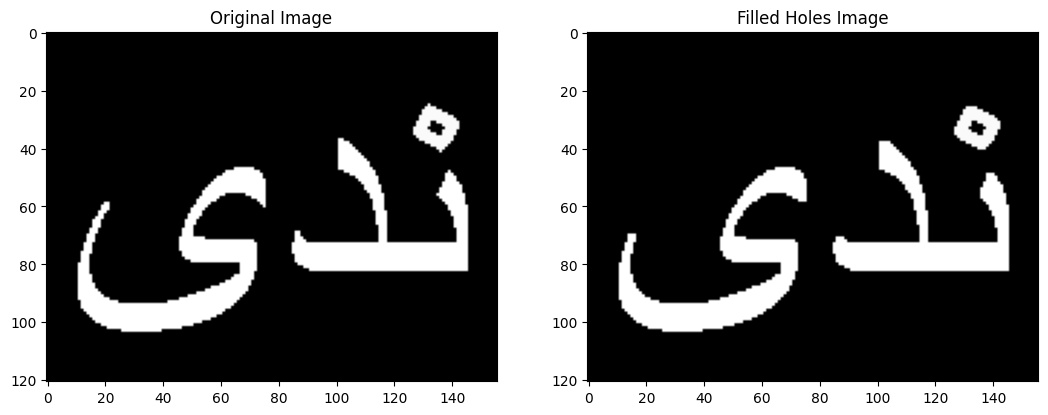

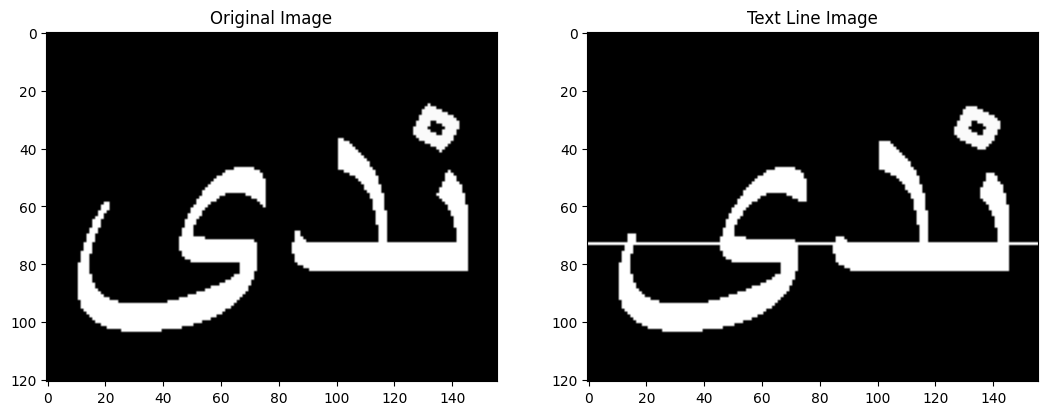

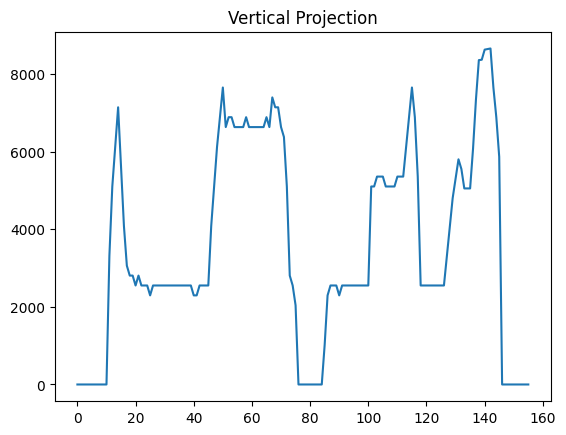

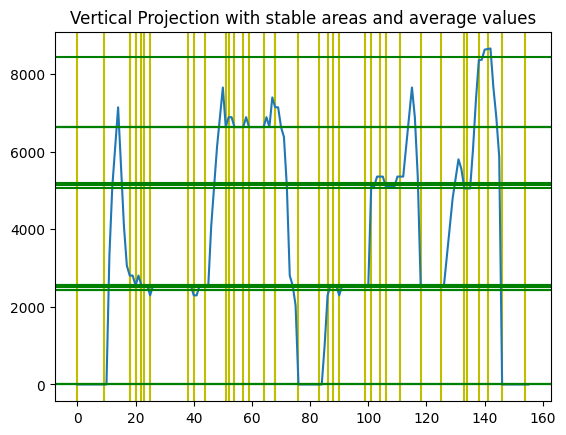

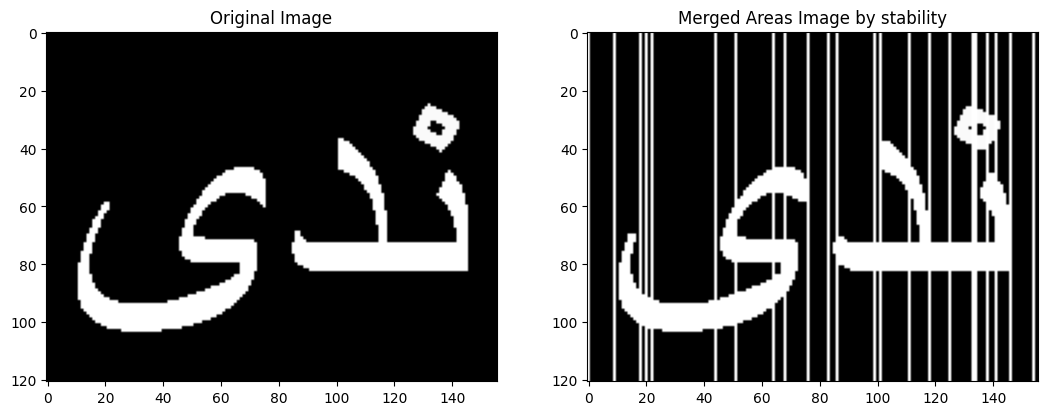

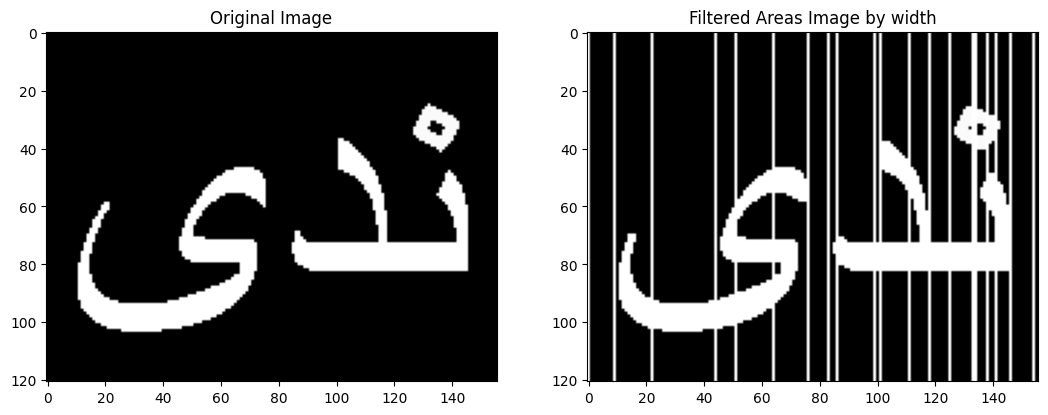

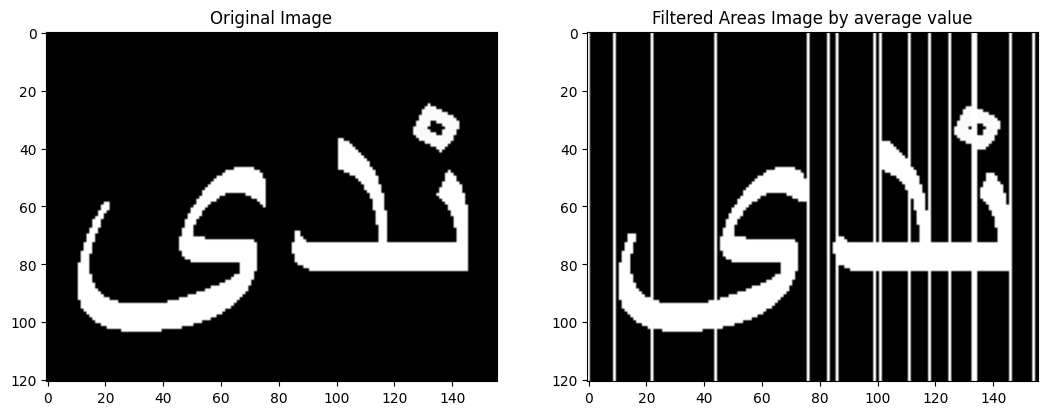

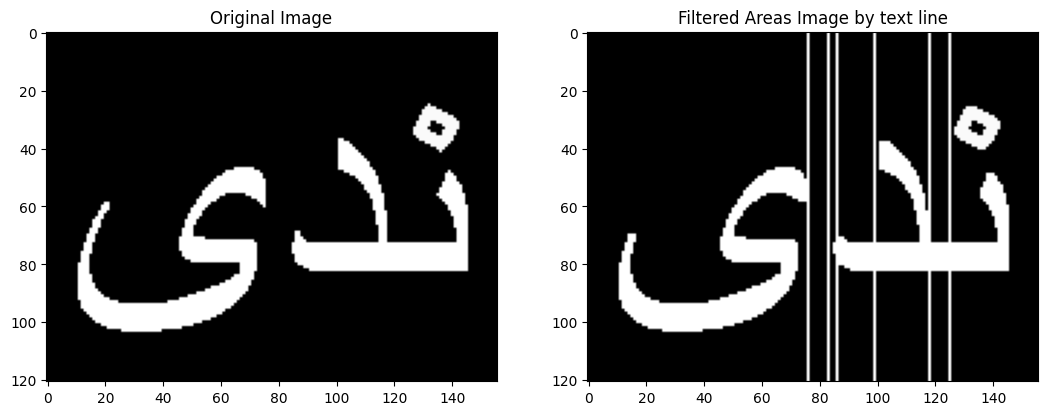

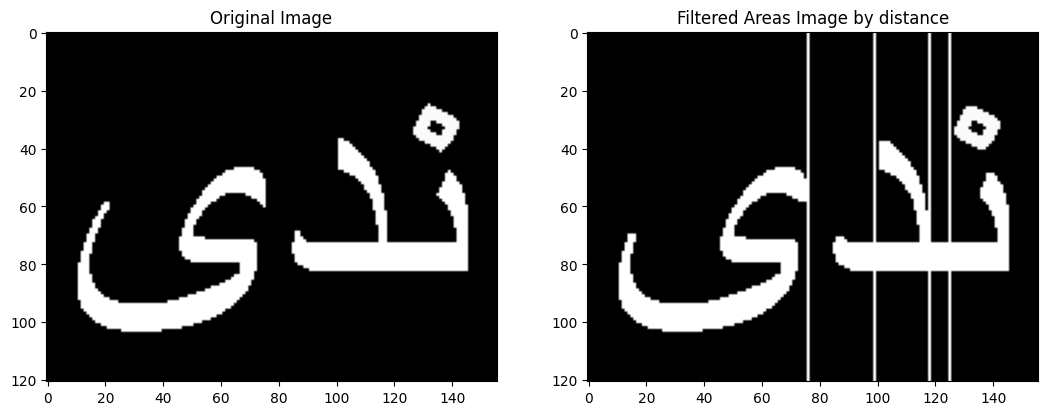

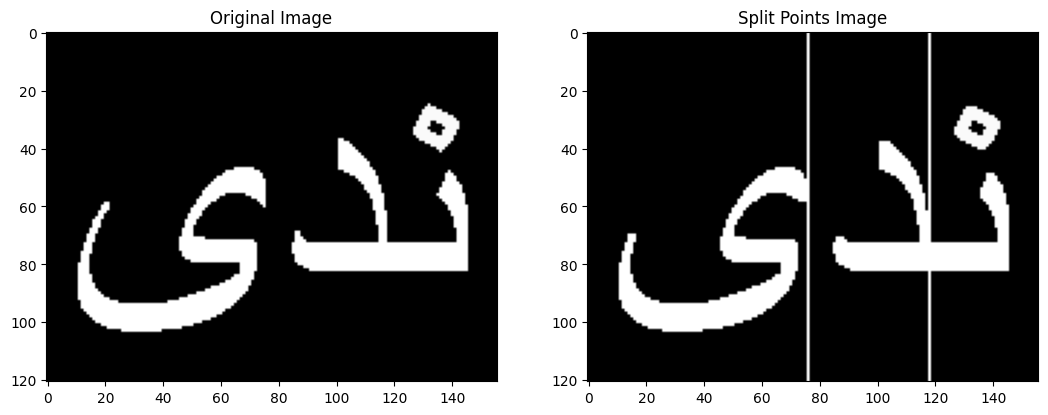

words: 3


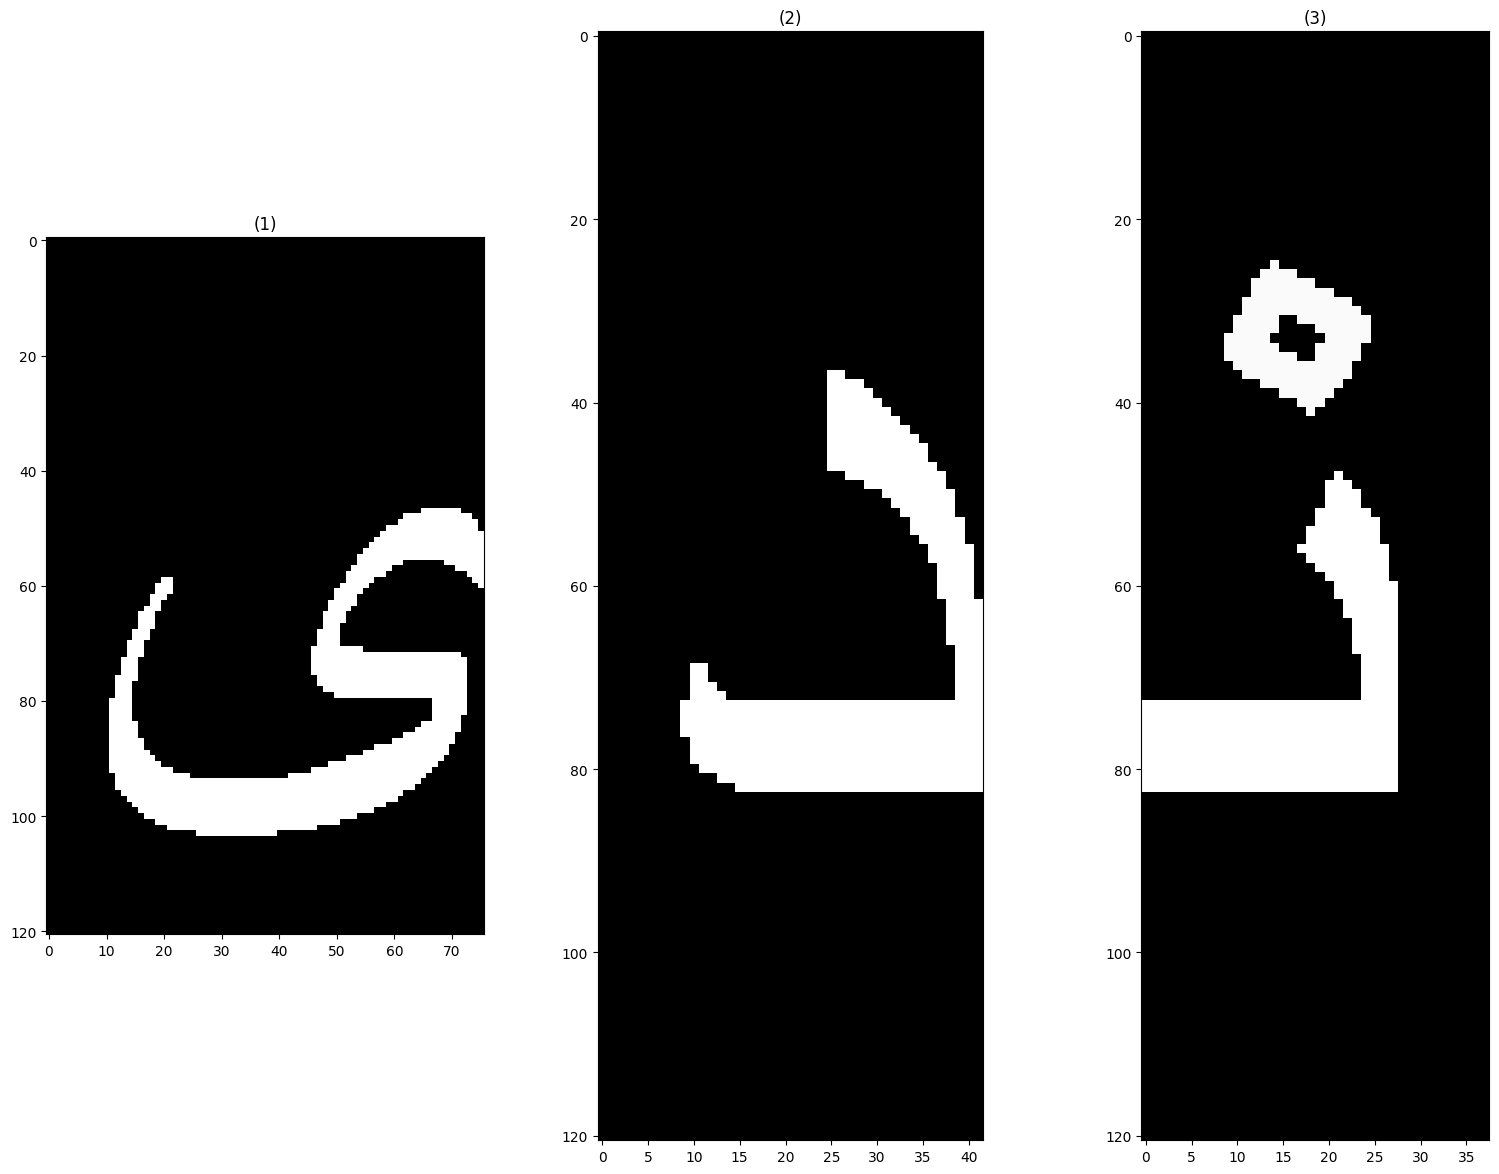

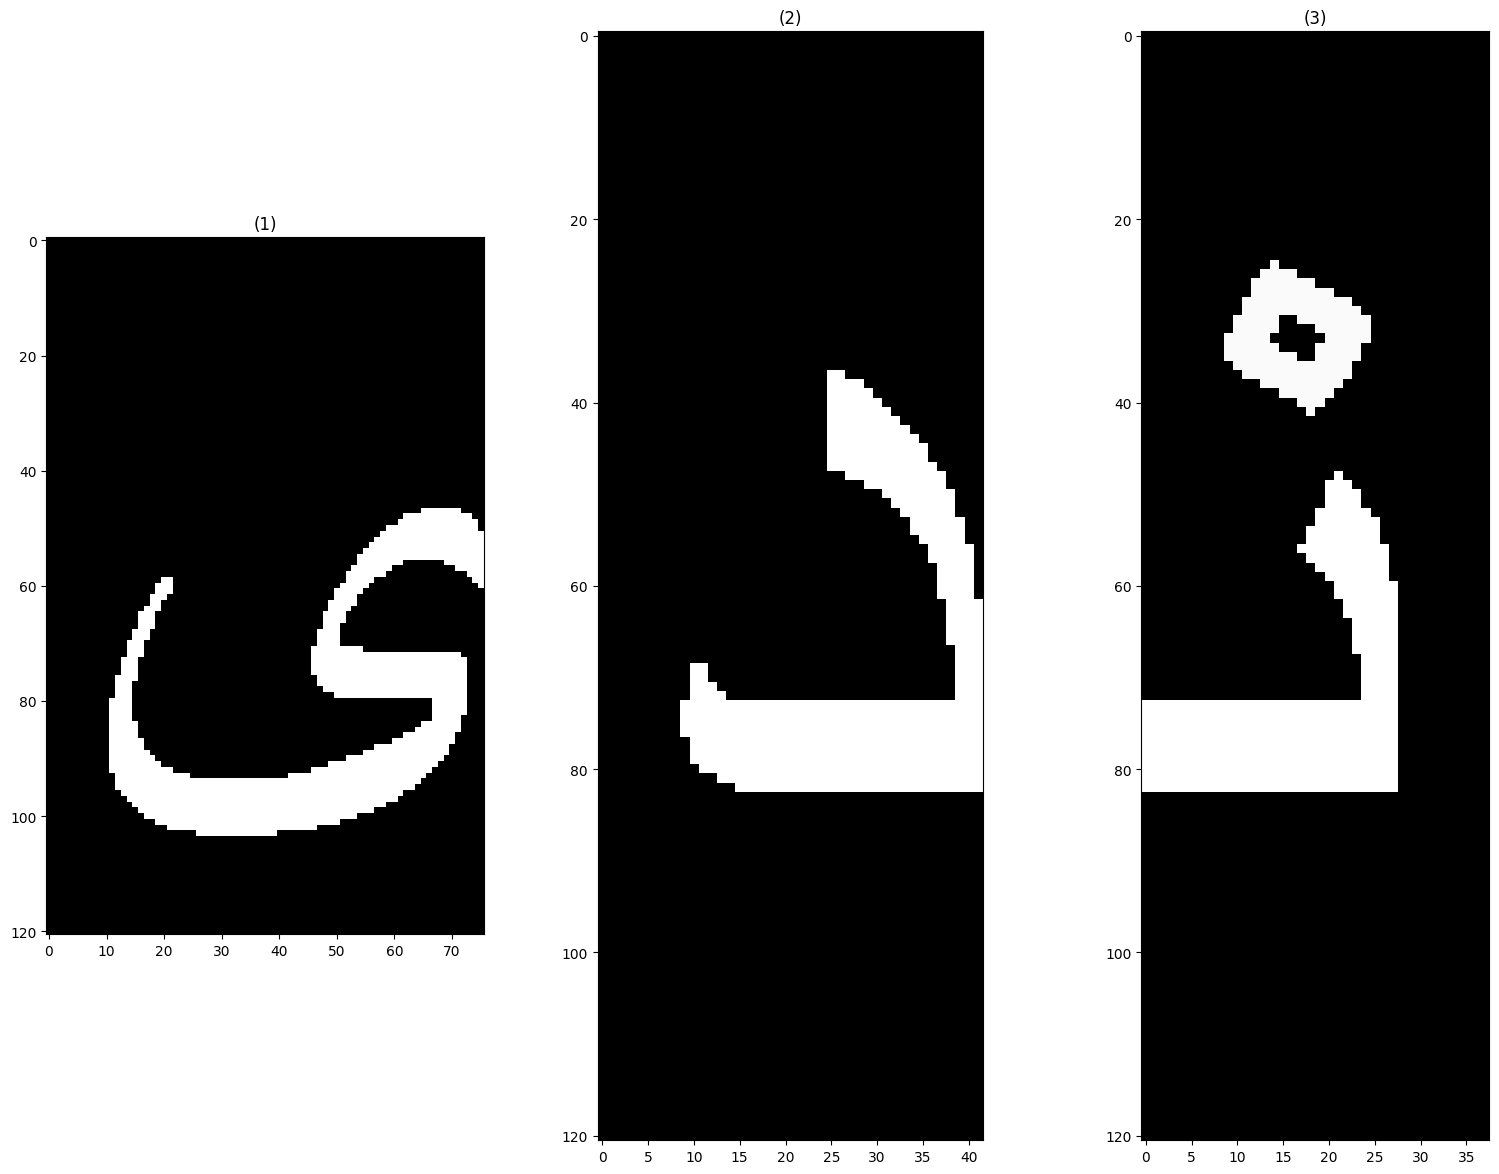

In [531]:
path = 'D:/UNI/CCE_sem_8_LAST_YAY_^^/gp2/project/Alfarahifi_org/arabic-ocr/Trial/computer_par/line_0/word_1.png'

words = segment_characters(path)


filtered_words = filter_words(words)

show_images(words)
show_images(filtered_words)